In [1]:
import torch
from directed_graphs.multiscale_flow_embedder import MultiscaleDiffusionFlowEmbedder
from directed_graphs.datasets import directed_swiss_roll
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import scvelo as scv
import numpy as np
scv.set_figure_params()
adata = scv.datasets.pancreas()

In [3]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [4]:
scv.tl.velocity(adata, mode='stochastic',n_jobs=10)

computing velocities
    finished (0:00:09) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [5]:
scv.tl.velocity_graph(adata,n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


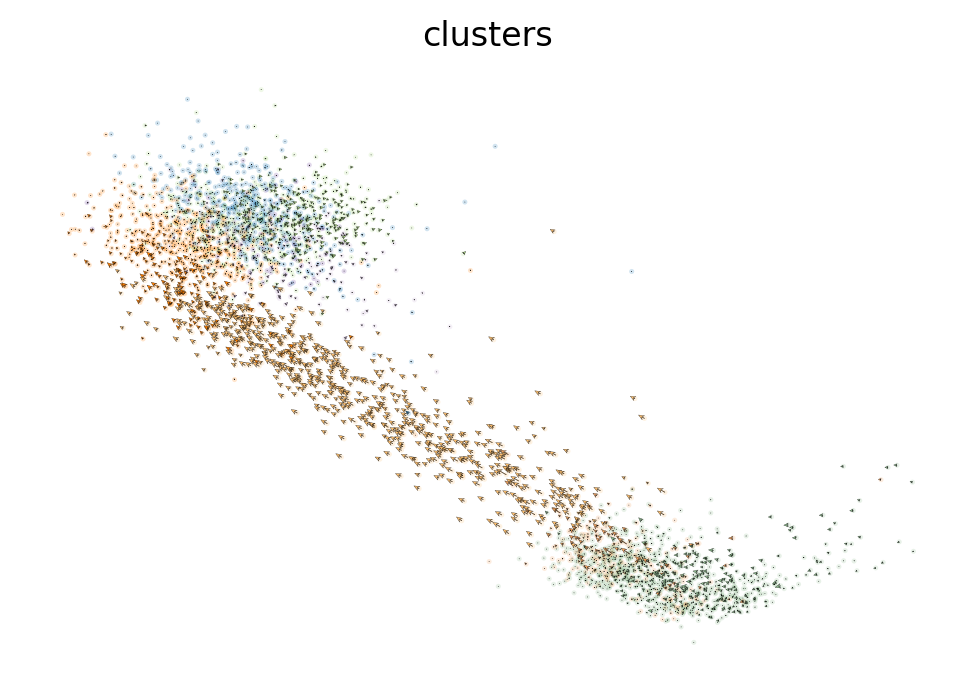

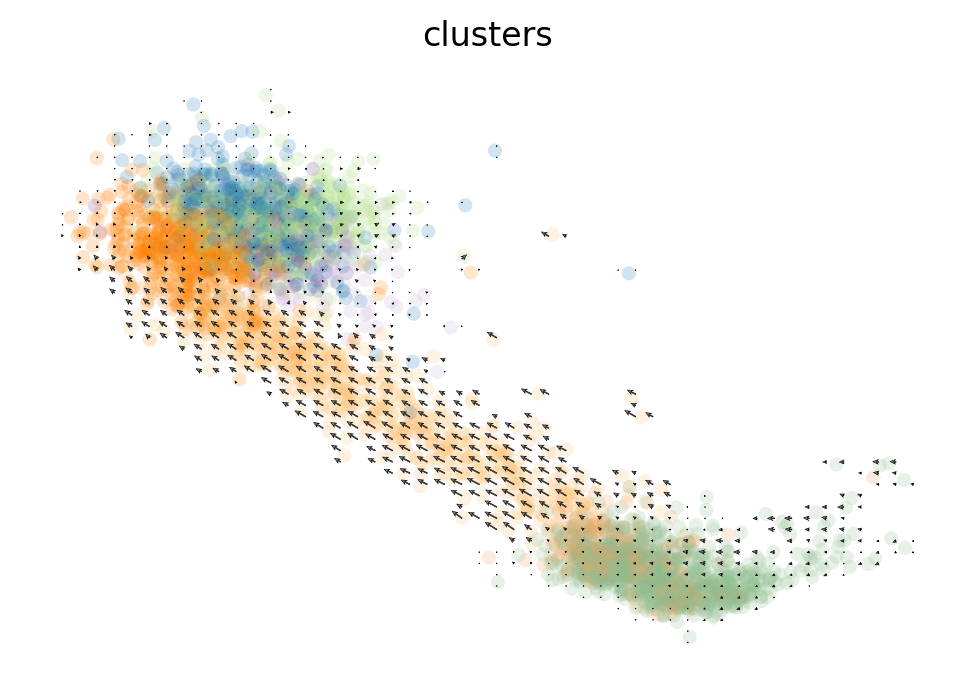

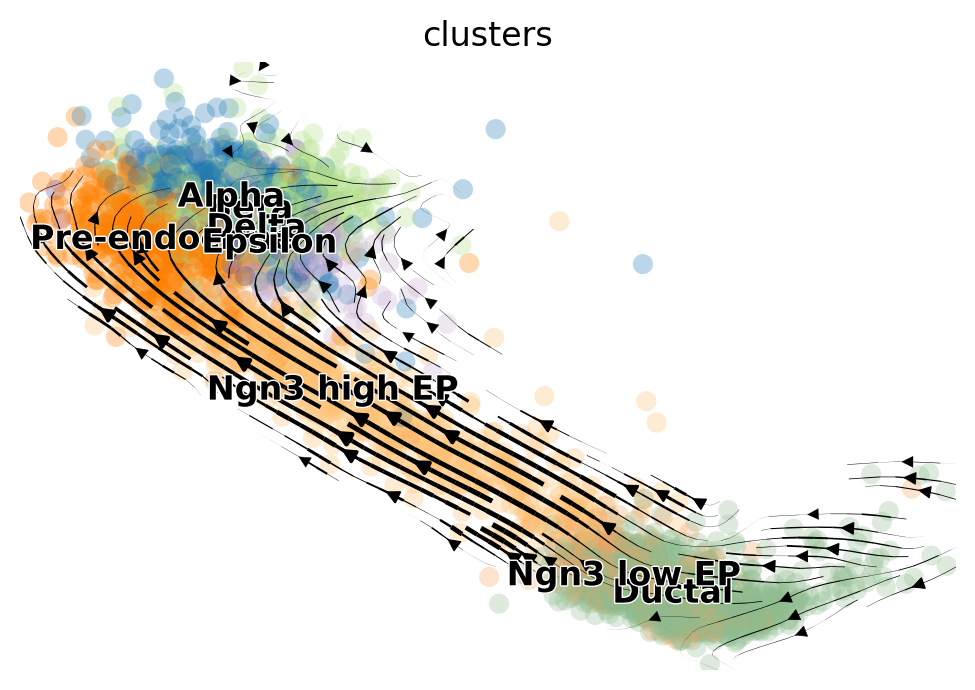

In [6]:
scv.pl.velocity_embedding(adata, basis='pca')
scv.pl.velocity_embedding_grid(adata, basis='pca')
scv.pl.velocity_embedding_stream(adata, basis='pca')

In [7]:
import scipy
X = scipy.sparse.csr_matrix.todense(adata.X)
X = torch.tensor(X)
flow = torch.tensor(adata.layers["velocity"])
X = X.float().to(device)
flow = flow.float().to(device)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
X = torch.tensor(adata.obsm["X_pca"])
flow = torch.tensor(adata.obsm["velocity_pca"])
X = X.float().to(device)
flow = flow.float().to(device)

In [ ]:
from directed_graphs.datasets import affinity_grid_search

In [ ]:
cluster_set = set(adata.obs["clusters"])
print(len(cluster_set))

In [ ]:
d = {}
count = 0
for c in cluster_set:
    d[c] = count
    count +=1
l = []
for i in range(len(adata.obs["clusters"])):
    l.append(d[adata.obs["clusters"][i]])

In [ ]:
lw = {"diffusion":1,"smoothness":0,"reconstruction":0,"diffusion map regularization":0,"flow cosine loss":0}
MFE = MultiscaleDiffusionFlowEmbedder(X=X, flows=flow, device=device, loss_weights=lw).to(device)
MFE = MFE.to(device)

In [ ]:
embeddings = MFE.fit(n_steps=1000)

In [ ]:
!nvidia-smi